# Задача

Приток новых игроков делится на 2 основных источника - рекламный и органический. Отдел маркетинг выдвигает гипотезу о связи рекламного и органического траффика: когда маркетологи привлекают больше рекламного траффика, растет и органический.

Для выполнения задачи необходимо использовать тестовый датасет (таблица source_comparison).

- Подтвердите или опровергните гипотезу маркетологов. Если вы ее опровергаете, то сформулируйте гипотезу которая кажется вам наиболее вероятной и проверьте ее
- Количественно рассчитайте вероятность что гипотеза маркетологов (или ваша) верна

# Решение

In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [2]:
# подключимся к тестовой бд
connect = sqlite3.connect("testcase.db")

In [3]:
# переведем в датафрейм
df = pd.read_sql_query("SELECT * FROM source_comparison", connect)

In [4]:
def get_dataset_info(df: pd.DataFrame) -> None:
    """
    Функция выводит общую инфу
    о датасете одним полем
    
    :param pd.DataFrame df: pandas-датафрейм, который нужно проанализировать
    """
    display(df.head())
    print('\n')
    print(df.info())
    print('\n')
    display(df.describe())
    print('\n')
    print(df.isna().sum())
    print('\n')
    print(f'Дубликаты: {df.duplicated().sum()}')
    print('it`s over')

In [5]:
# получим общую инфу о представленных данных
get_dataset_info(df)

,Install_Dates,source_type,Country,installs
0,2020-05-18,Paid,PY,4.0
1,2020-04-14,Paid,FR,35.0
2,2020-04-30,Paid,JP,25.0
3,2020-03-20,Paid,DE,11.0
4,2020-04-30,Paid,IT,8.0




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18606 entries, 0 to 18605
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Install_Dates  18606 non-null  object 
 1   source_type    18606 non-null  object 
 2   Country        18606 non-null  object 
 3   installs       18606 non-null  float64
dtypes: float64(1), object(3)
memory usage: 581.6+ KB
None




,installs
count,18606.000000
mean,51.968451
std,227.810616
min,1.000000
25%,2.000000
50%,6.000000
75%,22.000000
max,5633.000000




Install_Dates    0
source_type      0
Country          0
installs         0
dtype: int64


Дубликаты: 679
it`s over


Вроде проблем никаких нет, за исключением 679 полных дубликата. Дубликаты в целом не очень хорошо, поэтому от них избавимся, чтобы не смазали картину.

In [6]:
df = df.drop_duplicates()
df.duplicated().sum()

0

Нас в первую очередь интересуют столбцы с видом трафика и количеством установок.

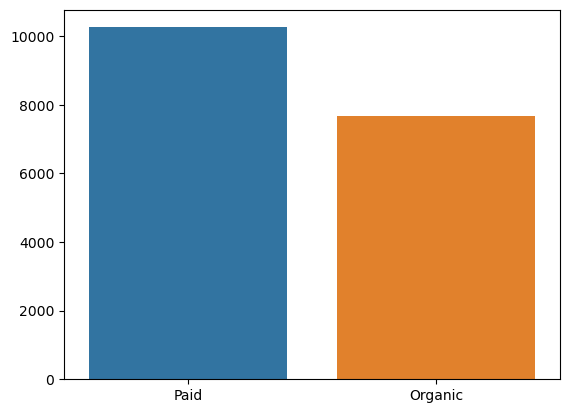

In [7]:
sns.barplot(pd.DataFrame(df['source_type'].value_counts()).T);

Записей рекламного трафика больше, но пока что нельзя сказать что-то с уверенностью. Посмотрим на кол-во установок в формате временного ряда.

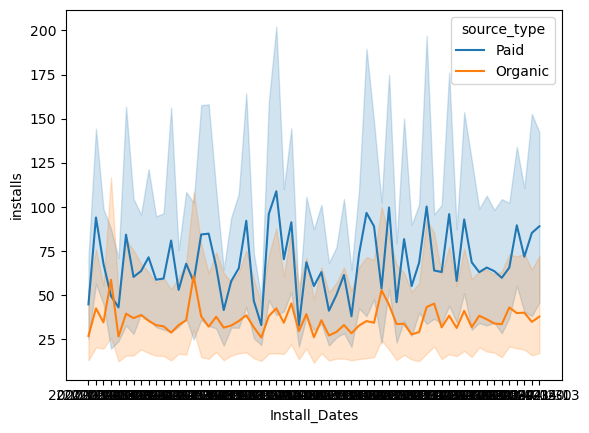

In [8]:
sns.lineplot(data=df, x=df['Install_Dates'], y=df['installs'], hue=df['source_type']);

В целом, визуально можно увидеть, что графики оказываются похожими, но сказать точно не получится. У нас сливаются многочисленные даты, поэтому можно провести ресамплирование.

In [9]:
# сконвертируем даты в нужный тип
df['Install_Dates'] = pd.to_datetime(df['Install_Dates'], format='%Y-%m-%d')

In [10]:
# посмотрим временной отрезок
df['Install_Dates'].min(), df['Install_Dates'].max()

(Timestamp('2020-03-18 00:00:00'), Timestamp('2020-05-18 00:00:00'))

У нас два месяца, так что можно посмотреть по неделям, аггрегируя средние значения.

In [11]:
# подготовим для ресамплирования
data_resample = df[['Install_Dates', 'installs', 'source_type']]
data_resample = data_resample.set_index('Install_Dates')
data_resample.sort_index(inplace=True)
data_resample.head()

,installs,source_type
Install_Dates,,
2020-03-18,1.0,Organic
2020-03-18,2.0,Organic
2020-03-18,74.0,Organic
2020-03-18,11.0,Organic
2020-03-18,22.0,Paid


In [12]:
data_resample_paid = data_resample.loc[data_resample['source_type'] == 'Paid'].resample('1W').mean()
data_resample_org = data_resample.loc[data_resample['source_type'] == 'Organic'].resample('1W').mean()

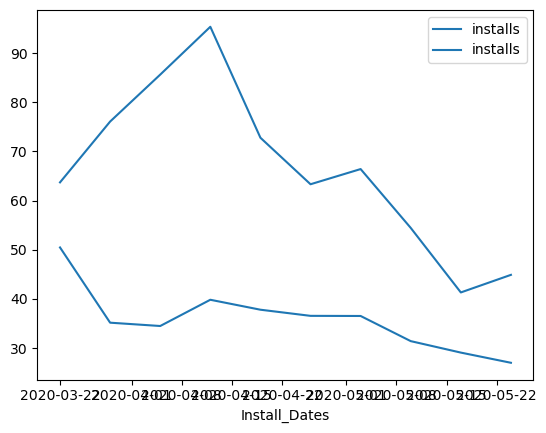

In [13]:
sns.lineplot(data_resample_paid)
sns.lineplot(data_resample_org);

В таком виде связь прослеживается уже не так хорошо, но в целом на глаз сравнивать связь в этом случае будет не самой лучшей затеей, если она не бросается сразу в глаза. Если у нас есть значения, то можем посчитать линейную корреляцию значений Пирсона, чтобы проверить, будет ли при возрастании рекламного трафика возрастать органический.

In [14]:
# сделаем сводную таблицу с суммой установок за каждую в наличии дату по двум каналам привлечения
df_pivot = df.pivot_table(index='Install_Dates', columns='source_type', values='installs', aggfunc='sum')
df_pivot.head()

source_type,Organic,Paid
Install_Dates,,
2020-03-18,8961.0,7339.0
2020-03-19,8457.0,6731.0
2020-03-20,8819.0,7243.0
2020-03-21,4485.0,9482.0
2020-03-22,5105.0,14751.0


In [15]:
# посчитаем коэф. корреляции Пирсона силами pandas
df_pivot['Organic'].corr(df_pivot['Paid'])

0.21951848635126378

К сожалению, нельзя сказать о том, что кол-во установок, привлеченных рекламным и органическим трафиком, линейно коррелируют между собой. Корреляция ненулевая, но слабая. Мы не будем здесь проверять нормальность распределения значений, а величины у нас непрерывные, поэтому Пирсон в целом должен подойти. Если бы были какие-то ранговые значения, то взяли бы коэффициент Спирмена. Мне кажется, что прямой связи между видами трафика нет, а связь (где-то она может быть) не будет 100%. При этом затрудняюсь назвать какие-либо вероятности своей правоты, тут скорее какой интервал посчитаем доверительным. Я бы предложил оценить гораздо большие исторических данных, чем 2 месяца, либо проверить без запуска рекламного трафика, если это возможно.

Еще можно попробовать построить модель линейной регрессии, а потом оценить полученные коэффициенты методом наименьших квадратов. Еще не стал заострять внимание на признаке страны, но это в теории тоже может оказать влияние, так как вдруг рекламные кампании затрагивали только определенные страны, следовательно, сравнивать стоило бы только их.